# Homework 1
## by Bogdan Alexandrov
## for the course "Models of sequential data"

We will consider the estimation for MA model for a particular dataset.
There are 5 problems in this homework.
* The first 4 problems are obligatory. 
* You can earn bonus points by making progress on the problem 5.

You have two weeks to complete the homework. The strict deadline is **17:00 $7$th of December, Moscow time**. 
No points will be awarded for the homework submitted after the deadline.


The name of the notebook should be in format *msd_hw_1_xxx.ipynb*, where *xxx* is your last name. E.g. *msd_hw_1_zaytsev.ipynb*.
Homeworks that fail to meet these guidelines, would have zero points as the grade.

## Problems 1-3. Estimation for MA models

### Problem 1. [10 points] 
Write a python class that defines ARMA model. 
* Problem 1.1. [5 points] Define the *initialize* method to initialize parameters of the model given orders for $ARMA(p, q)$
* Problem 1.2. [5 points] Define the *predict* method that can use ARMA to predict for one step and for $k$ steps ahead given the parameters of the model

### Problem 2. [15 points] 
Write a python method to *fit* the MA model of order $q$. 
I suggest to use the Least Squares method from the book "Time Series Analysis with Applications in R", Section 7.2 Least Squares Estimation. The book is freely available on the internet.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [28]:
class ARMA:
    def __init__(self, p, q):
        self.p = p
        self.q = q
    
    def predict(self, X, k=1):
        assert k > 0
        
        past_noise = self.noise[:-self.q-1:-1]
        past = self.past[:-self.p-1:-1]
        prediction = np.array([0 for _ in range(k)])
        for i in range(k):
            prediction[i] = X[i] + (self.ma * past_noise).sum() + (self.ar * past).sum()
            
            if self.q:
                past_noise = np.hstack((X[i], past_noise[:-1]))
            
            if self.p:
                past = np.hstack((prediction[i], past[:-1]))

        return prediction
    
    def fit(self, noise, process):
        self.noise = noise.copy()
        self.past = process.copy()
        
        data_copy = np.append(self.noise[::-1], np.array([0 for _ in range(self.q-1)]))
        
        X = data_copy[1:1+self.q]
        y = process[1:]
        for i in range(2, self.noise.size):
            X = np.vstack((X, data_copy[i:i+self.q]))

        self.ma = np.linalg.inv(X.T @ X) @ X.T @ y[::-1]
        self.ar = np.array([])
    
    def get_params(self):
        return self.ma

### Problem 3. [15 points] 
Validate the *fit* method you wrote
* Problem 3.1. [5 points] Write a procedure that generates a sequencse for $MA(p)$ process with pre-defined parameters
* Problem 3.2. [10 points] Fit it using your methods and check the quality of forecasting and the quality of the parameter estimation. You can use scatter plots and MSE error for validation in this case.

Let q be 10:

In [29]:
q = 10
coefs = np.random.normal(size=q+1)
coefs[0] = 1
print(coefs)

[ 1.          0.58107217  0.97488015  1.3405208  -0.84069499 -0.96398287
  2.52529187  1.65032761  0.97328635  0.34314714 -0.76132132]


One placed at the beginning for simplifying usage of convolution, because $Y_t = 1*\epsilon_t + \ldots$

Generate-function return noise and MA process.

In [30]:
def gen_MA(size = 1000, sigma=1):    
    noise = np.random.normal(0, sigma, size)
    process = np.convolve(noise, coefs)[:len(noise)]
    return process, noise

In [31]:
process, noise = gen_MA()
X_train, X_test = noise[:899], noise[900:]
y_train, y_test = process[:899], process[900:]

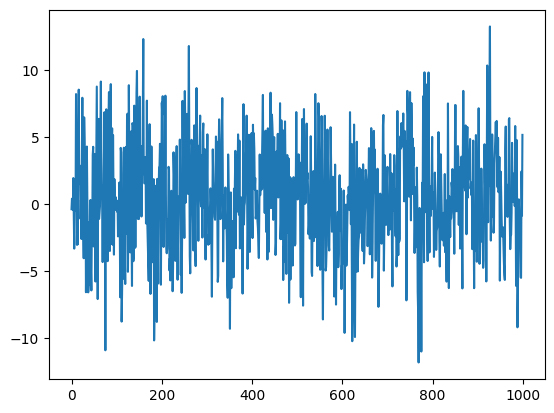

In [32]:
plt.plot(process)
plt.show()

In [33]:
model = ARMA(0, q)
model.fit(X_train, y_train)

Let's predict first k=10 steps:

In [34]:
pred = model.predict(X_test, 10)

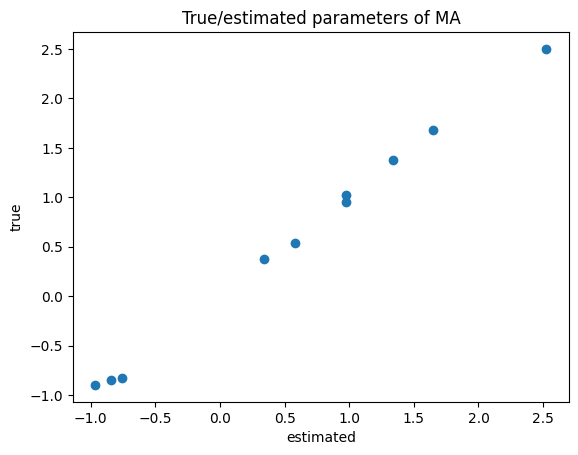

In [35]:
plt.scatter(coefs[1:], model.get_params())
plt.title("True/estimated parameters of MA")
plt.xlabel("estimated")
plt.ylabel("true")
plt.show()

As we can see, estimated parameters close to real.

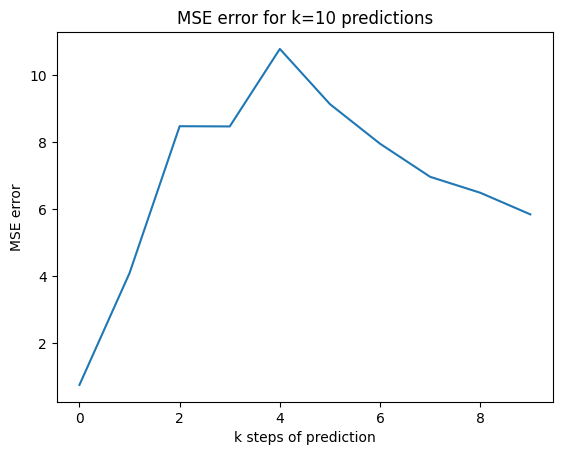

In [44]:
plt.plot([((y_test[:i] - pred[:i])**2).mean() for i in range(1,11)])
plt.title('MSE error for k=10 predictions')
plt.xlabel('k steps of prediction')
plt.ylabel('MSE error')
plt.show()

Now predict whole 100 left targets:

In [38]:
pred = model.predict(X_test, 100)

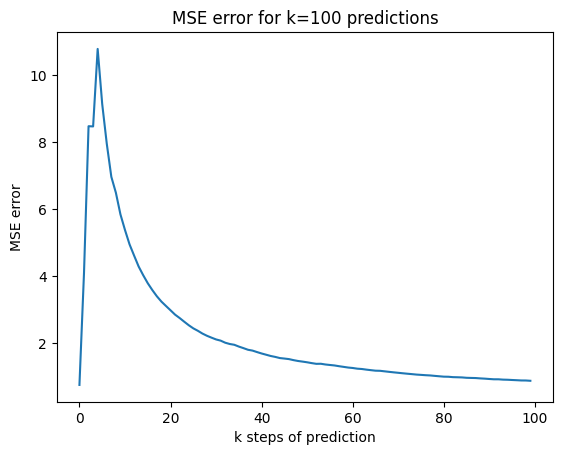

In [42]:
plt.plot([((y_test[:i] - pred[:i])**2).mean() for i in range(1,101)])
plt.title('MSE error for k=100 predictions')
plt.xlabel('k steps of prediction')
plt.ylabel('MSE error')
plt.show()

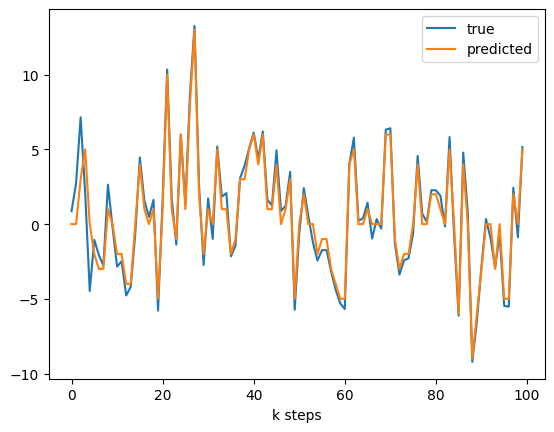

In [48]:
plt.plot(y_test, label='true')
plt.plot(pred, label='predicted')
plt.xlabel('k steps')
plt.legend()
plt.show()

## Problem 4.  Stationarity for AR process [10 points]
It is known, that the AR(p) process defined by the equation of the form 
$$
y_t = \phi_1 y_{t - 1} + \phi_2 y_{t - 2} + \ldots + \phi_p y_{t - p}.
$$
is weakly stationary if only if all roots of the regular characteristic polynomial have absolute values smaller than $1$.
The  regular characteristic polynomial has the form:
$$
R(\lambda) = \lambda^p - \phi_1 \lambda^{p - 1} - \ldots - \phi_p.
$$
Its roots are $\lambda_i$, $ i = 1, \ldots, p$. So, $\forall{i} \,\,  R(\lambda_i) = 0$.

Prove:
* Problem 4.1. [5 points] *Necessary condition:* If the process $AR(p)$ is weakly stationary, then $\sum_{i = 1}^p \phi_i < 1$.
* Problem 4.2. [5 points] *Sufficient condition:* If $\sum_{i = 1}^p |\phi_i| < 1$, then the corresponding process $AR(p)$ is weakly stationary.

    Problem 4.1
   Since all roots lies in unit circle, there no root has real value bigger than 1. Thus, on interval $[1, \infty]$ function $R(\lambda)$ has only one sign, in other words $R(\lambda) > 0$ or $R(\lambda) < 0$. Otherwise, there exists such $\lambda^*$, that $R(\lambda^*)=0$, due to continuity of polynomial. Which is contradiction to condition that all roots in unit circle. And because of $R(\lambda) > 0$ for large $\lambda >> 1$, we have that $R(\lambda) > 0\ \forall \lambda \in [1, \infty]$. And thus:
   $$R(1)=1-\phi_1-\ldots-\phi_p = 1 - \sum\limits_{i=1}^p \phi_i >0 \to \sum\limits_{i=1}^p \phi_i < 1$$
    
    Problem 4.2
    
   We have condition: $\sum_{i = 1}^p |\phi_i| < 1$. Thus:
   $$\forall i\ R(\lambda_i) = \lambda_i^p - \phi_1 \lambda_i^{p-1}-\ldots - \phi_p = 0$$
   $$\lambda_i^p = \phi_1 \lambda_i^{p-1}+\ldots + \phi_p \to \lambda_i = \phi_1 +\ldots + \phi_p \lambda_i^{1-p}$$
   $$|\lambda_i|=|\phi_1 +\ldots + \phi_p \lambda_i^{1-p}| \leq \sum\limits_{j=1}^p|\phi_j|\frac{1}{|\lambda_i|^{j-1}}$$
   So, if $|\lambda_i| \geq 1 \to \frac{1}{|\lambda_i|} \leq 1$, then:
   $1 \leq |\lambda_i| \leq \sum\limits_{j=1}^p|\phi_j|\frac{1}{|\lambda_i|^{j-1}} \leq \sum\limits_{j=1}^p|\phi_j| < 1$ which is contradiction. Thus we have: $|\lambda_i| < 1 \forall i$. So, AR(p) is weakly stationary.

## Problem 5. Gradient explosion* [20 points]

We consider a block in the recurrent neural network $h^t, x^t \in \mathbb{R}$:
$$
h^t = \phi(w_x x^t + w_h h^{t - 1} + b),
$$
where $\phi$ is the activation for the probit regression, CDF for the Gaussian distribution $\mathcal{N}(0, \sigma^2)$.
* Problem 5.1. [5 points] Find numerically or analytically (check, if possible) the expectation of the $\frac{\partial h^t}{\partial w_h}$ given $w_h \sim \mathcal{N}(0, \sigma^2)$.
* Problem 5.2. [5 points] Find numerically or analytically (check, if possible) the expectation of the $h^t$ given $w_h \sim \mathcal{N}(0, \sigma^2)$. In what cases we can get a stationary distribution for $h^t$?
* Problem 5.3. [10 points] Find the critical values for $\sigma^2$: in what case we'll have the explosion of the norm $\prod_{t = 1}^\infty \|\frac{\partial h^t}{\partial w_h} \| $? Provide numerical or analytical solution, if possible.

    Problem 5.1
$$\frac{\partial h^1}{\partial w_h}=\frac{\partial\phi(z)}{\partial z}|_{w_x x^1 + w_h h^{0} + b} * h^{0}$$
Since $\frac{\partial \phi(z)}{\partial z} = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{z^2}{2\sigma^2}}$:
$$\frac{\partial h^1}{\partial w_h} = \frac{h^{0}}{\sqrt{2\pi\sigma^2}}e^{-\frac{(w_x x^1 + w_h h^{0} + b)^2}{2\sigma^2}}$$

General formula: $$\frac{\partial h^t}{\partial w_h} = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{(w_x x^t + w_h h^{t-1} + b)^2}{2\sigma^2}}(h^{t-1}+w_h\frac{\partial h^{t-1}}{\partial w_h})$$

$$\mathbb{E}_{N(0, \sigma^2)}(\frac{\partial h^1}{\partial w_h}) = \int_{-\infty}^{\infty} \frac{h^{0}}{\sqrt{2\pi\sigma^2}}e^{-\frac{(w_x x^1 + w_h h^{0} + b)^2}{2\sigma^2}} * \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac{w_h^2}{2\sigma^2}} dw_h = \frac{h^{0}}{2\pi\sigma^2}\int_{-\infty}^{\infty} e^{-\frac{(w_x x^1 + w_h h^{0} + b)^2+w_h^2}{2\sigma^2}}dw_h = \frac{h^{0}}{2\pi\sigma^2} e^{-\frac{(w_x x^1 + b)^2}{2\sigma^2}} \int_{-\infty}^{\infty} e^{-\frac{w_h^2((h^{0})^2+1)+2w_h(w_x x^1 h^{0}+h^{0}b)}{2\sigma^2}} dw_h$$

$$e^{-\frac{w_h^2((h^{0})^2+1)+2w_h(w_x x^1 h^{0}+h^{0}b)}{2\sigma^2}} = e^{-\frac{(w_h\sqrt{(h^{0})^2+1}+\frac{w_x x^1 h^{0}+h^{0}b}{\sqrt{(h^{0})^2 + 1}})^2}{2\sigma^2}}*e^{\frac{(w_x x^1 h^{0}+h^{0}b)^2}{2\sigma^2((h^{0})^2 + 1)}}$$

$$\int_{-\infty}^{\infty} e^{-\frac{w_h^2((h^{0})^2+1)+2w_h(w_x x^1 h^{0}+h^{0}b)}{2\sigma^2}} dw_h = \int_{-\infty}^{\infty} e^{-\frac{(w_h\sqrt{(h^{0})^2+1}+\frac{w_x x^1 h^{0}+h^{0}b}{\sqrt{(h^{0})^2 + 1}})^2}{2\sigma^2}}*e^{\frac{(w_x x^1 h^{0}+h^{0}b)^2}{2\sigma^2((h^{0})^2 + 1)}} dw_h = e^{\frac{(w_x x^1 h^{0}+h^{0}b)^2}{2\sigma^2((h^{0})^2 + 1)}} \int_{-\infty}^{\infty} e^{-\frac{(w_h\sqrt{(h^{0})^2+1}+\frac{w_x x^1 h^{0}+h^{0}b}{\sqrt{(h^{0})^2 + 1}})^2}{2\sigma^2}} dw_h = e^{\frac{(w_x x^1 h^{0}+h^{0}b)^2}{2\sigma^2((h^{0})^2 + 1)}} * \frac{\sqrt{2\sigma^2}}{\sqrt{(h^{0})^2 + 1}} *\int_{-\infty}^{\infty} e^{-\frac{(w_h\sqrt{(h^{0})^2+1}+\frac{w_x x^1 h^{0}+h^{0}b}{\sqrt{(h^{0})^2 + 1}})^2}{2\sigma^2}} d\frac{w_h * \sqrt{(h^{0})^2+1} + \frac{w_x x^1 h^{0}+h^{0}b}{\sqrt{(h^{0})^2 + 1}}}{\sqrt{2\sigma^2}}$$

Let be $z = \frac{w_h * \sqrt{(h^{0})^2+1} + \frac{w_x x^1 h^{0}+h^{0}b}{\sqrt{(h^{0})^2 + 1}}}{\sqrt{2\sigma^2}}$. 

$$\int_{-\infty}^{\infty} e^{-\frac{(w_h\sqrt{(h^{0})^2+1}+\frac{w_x x^1 h^{0}+h^{0}b}{\sqrt{(h^{0})^2 + 1}})^2}{2\sigma^2}} d\frac{w_h * \sqrt{(h^{0})^2+1} + \frac{w_x x^1 h^{0}+h^{0}b}{\sqrt{(h^{0})^2 + 1}}}{\sqrt{2\sigma^2}} = \int_{-\infty}^{\infty} e^{-z^2} dz = \sqrt{\pi}$$

$$\mathbb{E}_{N(0, sigma^2)}(\frac{\partial h^1}{\partial w_h}) = \frac{h^{0}}{2\pi\sigma^2} e^{-\frac{(w_x x^1 + b)^2}{2\sigma^2}} * e^{\frac{(w_x x^1 h^{0}+h^{0}b)^2}{2\sigma^2((h^{0})^2 + 1)}} * \frac{\sqrt{2\sigma^2}}{\sqrt{(h^{0})^2 + 1}} * \sqrt{\pi} = \frac{h^{0}}{\sqrt{2\pi\sigma^2((h^{0})^2 + 1)}} e^{-\frac{(w_xx^1+b)^2}{2\sigma^2((h^{0})^2+1)}}$$

For $t \geq 2$ it is hard to find expectation analytically, so we will find it numerically for some determined $x_t, b, \sigma^2, w_x, h^0$

In [9]:
from scipy.stats import norm

In [205]:
length = 10
x_t = np.random.uniform(-1,1, length)
b = 0
sigma = 1
w_x = 1
h_0 = 1

In [206]:
def gradient(h_prev, grad_prev, w_h, t=0, sigma=1):
    return norm(0, sigma).pdf(w_x * x_t[t] + w_h * h_prev + b) * (h_prev + w_h * grad_prev)

def expectation_grad_calc(t=1, exp_size=1000):
    h_prev = h_0
    grad_prev = 0
    
    res = 0
    for j in range(exp_size):
        w_h = np.random.normal(0, sigma)
        for i in range(t):
            grad_prev = gradient(h_prev, grad_prev, w_h, i, sigma)
            h_prev = norm(0, sigma).cdf(w_x * x_t[i] + w_h * h_prev + b)
        res += grad_prev
    return res / exp_size

In [207]:
for i in range(length):
    exp = expectation_grad_calc(i+1)
    print(f'Expectation of gradient with sigma={sigma} for t={i+1} is:{exp}')

Expectation of gradient with sigma=1 for t=1 is:0.13678811466175253
Expectation of gradient with sigma=1 for t=2 is:0.1549213589977719
Expectation of gradient with sigma=1 for t=3 is:0.15266194715789252
Expectation of gradient with sigma=1 for t=4 is:0.1421400268714317
Expectation of gradient with sigma=1 for t=5 is:0.22775091793829058
Expectation of gradient with sigma=1 for t=6 is:0.18365012348169546
Expectation of gradient with sigma=1 for t=7 is:0.15304464005915863
Expectation of gradient with sigma=1 for t=8 is:0.17012051768796044
Expectation of gradient with sigma=1 for t=9 is:0.11639817216166455
Expectation of gradient with sigma=1 for t=10 is:0.10932824408744161


    Problem 5.2
 $\mathbb{E}_{N(0, \sigma^2)}(h^t) = \int_{-\infty}^{\infty} \phi(w_x x_t + w_h h^{t-1} + b)\ d\phi(w_h) $

In [208]:
def expectation_calc(t=1, exp_size=1000):
    h_prev = h_0
    res = 0
    for j in range(exp_size):
        w_h = np.random.normal(0, sigma)
        for i in range(t):
            h_prev = norm(0, sigma).cdf(w_x * x_t[i] + w_h * h_prev + b)
        res += h_prev
    return res / exp_size

In [209]:
for i in range(length):
    exp = expectation_calc(i+1)
    print(f'Expectation with sigma={sigma} for t={i+1} is:{exp}')

Expectation with sigma=1 for t=1 is:0.3825171463862348
Expectation with sigma=1 for t=2 is:0.37287411261715564
Expectation with sigma=1 for t=3 is:0.5687118558143197
Expectation with sigma=1 for t=4 is:0.7335286057466235
Expectation with sigma=1 for t=5 is:0.5220547417972523
Expectation with sigma=1 for t=6 is:0.3437845771442409
Expectation with sigma=1 for t=7 is:0.48797185399108267
Expectation with sigma=1 for t=8 is:0.2403706149877228
Expectation with sigma=1 for t=9 is:0.43035508356094554
Expectation with sigma=1 for t=10 is:0.7839575892215689


If $h^t$ distribution stationary, it means, that for all $t \geq 1$ distribution of $h^t$ is equal. Thus, there mean and standart deviation also equal. Parameters $b, w_h, w_x, \sigma^2$ are determined for model, the only dynamic variable is $x_t$.

Thus we have: $$w_x x_t + w_h h^{t-1} + b = w_x x_{t-1} + w_h h^{t-2} + b$$
$$w_x (x_t - x_{t-1}) = w_h (h^{t-2} - h^{t-1})$$

If this equation holds for every $t \geq 1$, distribution of $h^{t}$ will be stationary. For example, if data such that $x_t = x_{t-1} +\frac{w_h}{w_x}(h_{t-2} - \phi(w_x x_{t-1} + w_h h_{t-2} + b))$

In [210]:
sigma = 2
w_h = np.random.normal(0, sigma)
w_x = 2
b = 0.2

In [211]:
def create_data():
    x_1 = -0.2
    res = [x_1]
    prev_h = h_0
    for i in range(1, 10):
        x = res[i-1] + w_h / w_x * (prev_h - norm(0, sigma).cdf(w_x * res[i-1] + w_h * prev_h + b))
        prev_h = norm(0, sigma).cdf(w_x * res[i-1] + w_h * prev_h + b)
        res.append(x)
    return res

In [212]:
data = create_data()

In [213]:
for t in range(1,11):
    h_prev = h_0
    res = 0
    for j in range(500):
        #w_h = np.random.normal(0, 2)
        for i in range(t):
            h_prev = norm(0, sigma).cdf(w_x * data[i] + w_h * h_prev + b)
        res += h_prev
    print(f"Expectation for t={i+1}", res / 500)

Expectation for t=1 0.46481109247722247
Expectation for t=2 0.47008274170156716
Expectation for t=3 0.47013479585473583
Expectation for t=4 0.4701353149685795
Expectation for t=5 0.4701353201459898
Expectation for t=6 0.4701353201976206
Expectation for t=7 0.4701353201981456
Expectation for t=8 0.4701353201981474
Expectation for t=9 0.4701353201981474
Expectation for t=10 0.4701353201981474


As we can see, expectation became similar.

    Problem 5.3

In [214]:
length = 500
x_t = np.random.uniform(-1,1, length)

In [226]:
def prod_grad(t=1, sigma=1):
    h_prev = h_0
    grad_prev = 0
    
    res = 1
    w_h = np.random.normal(0, sigma)
    for i in range(t):
        grad_prev = gradient(h_prev, grad_prev, w_h, i, sigma)
        res *= abs(grad_prev)
        h_prev = norm(0, sigma).cdf(w_x * x_t[i] + w_h * h_prev + b)
    return res

In [294]:
for s in [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 100, 1000, 5000]:
    print("product of grads:", prod_grad(100, s))

product of grads: 0.0
product of grads: 0.0
product of grads: 0.0
product of grads: 2.939075467150891e-210
product of grads: 4.0719711995941e-105
product of grads: 4.925970874459833e-105
product of grads: 9.136581524652341e-131
product of grads: 2.7251005168863927e-176
product of grads: 9.060249599723947e-250
product of grads: 0.0
product of grads: 0.0


Couldn't get explosion of gradient(

Maybe needed to find $\prod_{t = 1}^\infty \|\frac{\partial h^t}{\partial h^{t-1}} \| $

In [329]:
def gradient2(h_prev, grad_prev, w_h, t=0, sigma=1):
    return norm(0, sigma).pdf(w_x * x_t[t] + w_h * h_prev + b) * w_h 

In [348]:
def prod_grad2(t=1, sigma=1):
    h_prev = 5
    grad_prev = 0
    x_t = np.random.uniform(-100,100, length)
    res = 1
    w_h = np.random.normal(0, sigma)
    for i in range(t):
        grad_prev = gradient2(h_prev, grad_prev, w_h, i, sigma)
        res *= abs(grad_prev)
        h_prev = norm(0, sigma).cdf(w_x * x_t[i] + w_h * h_prev + b)
    return res

In [349]:
for s in [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 100, 1000, 5000, 10000]:
    print("product of grads:", prod_grad2(100, s))

product of grads: 0.0
product of grads: 0.0
product of grads: 0.0
product of grads: 2.5779257668339012e-214
product of grads: 1.757814296527622e-107
product of grads: 1.3803193042039675e-67
product of grads: 1.8074029425054903e-68
product of grads: 7.180241361532717e-79
product of grads: 7.066165762204295e-123
product of grads: 2.0035987614258422e-121
product of grads: 1.1050506933497933e-59
product of grads: 4.191786471549321e-73


In [350]:
prod_grad2(100, 10000)

7.580992601540917e-49